<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Inits" data-toc-modified-id="Imports-&amp;-Inits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports &amp; Inits</a></span></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Ignite-Testing" data-toc-modified-id="Ignite-Testing-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Ignite Testing</a></span></li><li><span><a href="#NLPBook-Testing" data-toc-modified-id="NLPBook-Testing-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>NLPBook Testing</a></span></li></ul></li><li><span><a href="#Inference" data-toc-modified-id="Inference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inference</a></span></li><li><span><a href="#Playground" data-toc-modified-id="Playground-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Playground</a></span></li></ul></div>

# Surname Classifier Using ElmanRNN

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pdb
import pandas as pd
import numpy as np
import torch
import re

from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from pathlib import Path

from ignite.engine import Events
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar

In [3]:
from surname.dataset import SurnameDataset
from surname.containers import DataContainer, ModelContainer
from surname.model import SurnameClassifier
from surname.trainer import IgniteTrainer
from surname.custom_engine import custom_evaluator
from consts import consts
vars(consts)

{'path': PosixPath('../data/surnames'),
 'workdir': PosixPath('../data/surnames/rnn_workdir'),
 'proc_dataset_csv': PosixPath('../data/surnames/surnames_with_splits.csv'),
 'model_dir': PosixPath('../data/surnames/rnn_workdir/models'),
 'vectorizer_json': PosixPath('../data/surnames/rnn_workdir/elman_vectorizer.json'),
 'metrics_file': PosixPath('../data/surnames/rnn_workdir/elman_metrics.csv'),
 'class_weights_pth': PosixPath('../data/surnames/rnn_workdir/class_weights.pth'),
 'char_embedding_sz': 100,
 'rnn_hidden_sz': 64,
 'bs': 64,
 'lr': 0.001,
 'n_epochs': 100,
 'device': 'cuda:3',
 'checkpointer_prefix': 'elman',
 'checkpointer_name': 'classifier',
 'es_patience': 5,
 'save_every': 2,
 'save_total': 5}

## Data Loading

In [4]:
df = pd.read_csv(consts.proc_dataset_csv)
print(df.shape)
df.head()

(10980, 4)


,nationality,nationality_index,split,surname
0,Arabic,15,train,Totah
1,Arabic,15,train,Abboud
2,Arabic,15,train,Fakhoury
3,Arabic,15,train,Srour
4,Arabic,15,train,Sayegh


In [5]:
dc = DataContainer(df, SurnameDataset, consts.vectorizer_json, consts.bs, is_load=False)

Creating and saving vectorizer


In [6]:
try:
  class_weights = torch.load(consts.class_weights_pth)
except FileNotFoundError:
  nationality_vocab = dc.nationality_vocab
  class_counts = df['nationality'].value_counts().to_dict()
  sorted_counts = sorted(class_counts.items(), key=lambda x: nationality_vocab.lookup_token(x[0]))
  freq = [count for _, count in sorted_counts]
  class_weights = 1.0/torch.tensor(freq, dtype=torch.float32)
  torch.save(class_weights, consts.class_weights_pth)

## Model

In [ ]:
classifier = SurnameClassifier(consts.char_embedding_sz, dc.vocab_size, dc.n_classes, consts.rnn_hidden_sz, \
                       padding_idx=dc.surname_vocab.mask_idx)
class_weights = class_weights.to(consts.device)
loss_fn = nn.CrossEntropyLoss(class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=consts.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, patience=1)
mc = ModelContainer(classifier, optimizer, loss_fn, scheduler)
mc.model

In [ ]:
itr = iter(dc.train_dl)

In [ ]:
inp,y = next(itr)
y_pred = mc.model(x,l)
loss_fn(y_pred, y)

## Training

In [ ]:
pbar = ProgressBar(persist=True)
metrics = {'accuracy': Accuracy(), 'loss': Loss(loss_fn)}

In [ ]:
ig = IgniteTrainer(mc, dc, consts, pbar, metrics)
ig.run()

## Testing

### Plots

In [7]:
training_metrics = pd.read_csv(consts.metrics_file)
training_metrics = training_metrics[:-1]

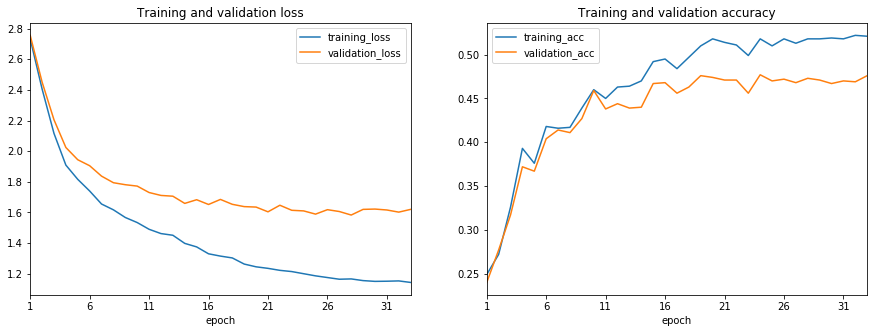

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
training_metrics.plot(x='epoch', y=['training_loss', 'validation_loss'], kind='line',
                      title='Training and validation loss', ax=axes[0])
training_metrics.plot(x='epoch', y=['training_acc', 'validation_acc'], kind='line',
                      title='Training and validation accuracy', ax=axes[1])

### Ignite Testing

In [14]:
classifier = SurnameClassifier(consts.char_embedding_sz, dc.vocab_size, dc.n_classes, consts.rnn_hidden_sz, \
                       padding_idx=dc.surname_vocab.mask_idx)
state_dict = torch.load(consts.workdir/'elman_classifier.pth')
classifier.load_state_dict(state_dict)
loss_fn = nn.CrossEntropyLoss(class_weights)
metrics = {'accuracy': Accuracy(), 'loss': Loss(loss_fn)}

In [15]:
evaluator = custom_evaluator(classifier, metrics=metrics)

@evaluator.on(Events.COMPLETED)
def log_testing_results(engine):
  metrics = engine.state.metrics
  print(f"Test loss: {metrics['loss']:0.3f}")
  print(f"Test accuracy: {metrics['accuracy']:0.3f}")

evaluator.run(dc.test_dl)

Test loss: 1.598
Test accuracy: 0.459


### NLPBook Testing

In [18]:
def compute_accuracy(y_pred, y_target):
  _, y_pred_indices = y_pred.max(dim=1)
  n_correct = torch.eq(y_pred_indices, y_target).sum().item()
  return n_correct / len(y_pred_indices) * 100

running_loss = 0.
running_acc = 0.

classifier.eval()
for i, batch in enumerate(dc.test_dl):
  model_inp,y = batch
  y_pred = classifier(*model_inp)
  
  loss = loss_fn(y_pred, y)
  loss_t = loss.item()
  running_loss += (loss_t-running_loss)/(i+1)
  
  acc_t = compute_accuracy(y_pred, y)
  running_acc += (acc_t-running_acc)/(i+1)

print(f"Test loss: {running_loss:0.3f}")
print(f"Test acc: {running_acc:0.3f}%")

Test loss: 1.691
Test acc: 45.625%


## Inference

In [39]:
import math

In [59]:
def predict_nationality(surname, classifier, vectorizer):
  vectorized_surname, vec_length = vectorizer.vectorize(surname, len(surname)+2)
  vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0) # bs of 1
  vec_length = torch.tensor([vec_length], dtype=torch.int64)
  
  result = classifier(vectorized_surname, vec_length, apply_softmax=True)
  assert(math.isclose(result.sum(dim=1).item(), 1.0, abs_tol=1e-7))
  prob_vals, idxs = result.max(dim=1)
  
  idx = idxs.item()
  prob_val = prob_vals.item()
  
  predicted_nationality = vectorizer.nationality_vocab.lookup_idx(idx)
  return {'nationality': predicted_nationality, 'probability': prob_val, 'surname': surname}

In [61]:
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho']:
  print(predict_nationality(surname, classifier, dc.vectorizer))

{'nationality': 'Irish', 'probability': 0.42430001497268677, 'surname': 'McMahan'}
{'nationality': 'Japanese', 'probability': 0.8683664798736572, 'surname': 'Nakamoto'}
{'nationality': 'Chinese', 'probability': 0.47296518087387085, 'surname': 'Wan'}
{'nationality': 'Korean', 'probability': 0.4813567101955414, 'surname': 'Cho'}


## Playground

In [ ]:
bs=3
hidden_sz=7
seq_sz =5 

In [ ]:
x_lens = torch.randint(1, seq_sz+1, (bs,))
x_lens = x_lens.long().detach().cpu().numpy()-1
y_out = torch.randn(bs, seq_sz, hidden_sz)

In [ ]:
print(x_lens.shape)
x_lens

In [ ]:
print(y_out.shape)
y_out

In [ ]:
out = []

for batch_idx, column_idx in enumerate(x_lens):
  out.append(y_out[batch_idx, column_idx])
#   print(batch_idx, column_idx)

In [ ]:
y = torch.stack(out)

In [ ]:
print(y.shape)
y

In [ ]:
bs=3
hidden_sz=7
seq_sz =5 

In [ ]:
from surname.elman import ElmanRNN
e = ElmanRNN(consts.char_embedding_sz, consts.rnn_hidden_sz, batch_first=True)

In [ ]:
inp = torch.randn(2,10,100)
e(inp)

In [ ]:
inp = inp.to('cuda:3')
e = e.to('cuda:3')

In [ ]:
inp = inp.cpu()
e = e.cpu()

In [ ]:
e(inp)

In [ ]:
x = torch.zeros(5, device='cuda:3')

In [ ]:
x